In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# Load and Pre-process Historical S&P 500 Data

In [3]:
df = pd.read_csv('ps6_data.csv')
df['Return'] = df['USD per Euro'] / df['USD per Euro'].shift(1) - 1
dates = pd.to_datetime (df.Date).values
r = df.Return[1:].values #the return vector
df

,Date,USD per Euro,Return
0,7/27/05,1.1990,NaN
1,7/28/05,1.2100,0.009174
2,7/29/05,1.2093,-0.000579
3,8/1/05,1.2219,0.010419
4,8/2/05,1.2217,-0.000164
...,...,...,...
1274,7/21/10,1.2817,-0.002102
1275,7/22/10,1.2850,0.002575
1276,7/23/10,1.2897,0.003658
1277,7/26/10,1.2931,0.002636


In [5]:
r

array([ 0.00917431, -0.00057851,  0.01041925, ...,  0.00365759,
        0.00263627,  0.00788802])

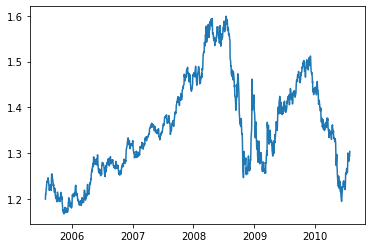

In [4]:
plt.plot(dates, df['USD per Euro'])
# plt.savefig('S&P500.pdf')  
plt.show()

# Estimating the Sample Volatility

In [11]:
# Method 1:
m = 1278
r_bar = np.mean(r)
v_sample = np.sum( np.power(r - r_bar, 2) ) / (m-1)
sigma_sample = np.sqrt(v_sample) * 100

r_bar, v_sample, sigma_sample

(8.788250233523879e-05, 4.525690817331785e-05, 0.6727325484419335)

In [12]:
# Method 2:
v_sample = np.sum( np.power(r, 2) ) / m
sigma_sample = np.sqrt(v_sample) * 100
v_sample, sigma_sample

(4.522921921631912e-05, 0.6725267222669975)

# Implementing the Maximum Likelihood Method

In [6]:
def get_GARCH_volatility (omega, alpha, beta):
    
    v = np.zeros_like(r) 

    v[0] = np.nan  #discard the first entry of v
    v[1] = r[0] * r[0] #the second entry of v

    #define v resursively under the basic GARCH (1,1) model
    for n in range(2, len(r)):
        v[n] = omega + alpha * r[n-1] * r[n-1] + beta * v[n-1] 
        
    return v


def get_EWMA_volatility (lamb):
    
    
    v = np.zeros_like(r) 

    v[0] = np.nan #discard the first entry of v 
    v[1] = r[0] * r[0] #the second entry of v

    #define v resursively under the EWMA model
    for n in range(2, len(r)):
        v[n] = lamb * v [n-1] + (1-lamb) * r[n-1] * r[n-1]
        
    return v


def get_GARCH_VT_volatility (alpha, beta):
        
    VL = np.power (np.std(r), 2) 
    omega = VL * (1 - alpha - beta)
    

    v = np.zeros_like(r) 

    v[0] = np.nan  #discard the first entry of v
    v[1] = r[0] * r[0] #the second entry of v

    #define v resursively under the basic GARCH (1,1) model
    for n in range(2, len(r)):
        v[n] = omega + alpha * r[n-1] * r[n-1] + beta * v[n-1] 
        
    return v

In [7]:
# Define the maximum likelihood method objective function 
# There are three modes: 'GARCH', 'EWMA', 'GARCH-VT'

def LL(paras, mode):

    #Initialize the parameters
    
    if mode == 'GARCH':
        omega = paras[0]/100000
        alpha = paras[1]/10
        beta = paras[2]
        v = get_GARCH_volatility (omega, alpha, beta)
        
        
    if mode == 'EWMA':
        lamb = paras
        
        ########################################
        #double check that lamb < 1 to improve numerical stability
        ########################################
        
        if lamb > 1:
            #print('Warning: lambda > 1')
            return  - np.exp(lamb - 1) 
        
        v = get_EWMA_volatility (lamb)
        
        
    if mode == 'GARCH-VT':
        alpha = paras[0]/10
        beta = paras[1]
        
        ########################################
        #double check that alpha + beta <= 1 to improve numerical stability
        ########################################
        
        
        if alpha + beta > 1:
            return  - np.exp(alpha + beta - 1) - 1
        
        v = get_GARCH_VT_volatility (alpha, beta)
        
    v = v[1:] #delte the first entry of v for likelihood calculation, because it is empty
    
    ########################################
    # Provide special values in case of overflow in increase the numerical stability
    ########################################
    if np.isinf(np.max(v)):
        print('Overflow warning, ', - np.max(v[np.isfinite(v)]) * 1000)
        return - np.max(v[np.isfinite(v)]) * 1000
    
    if np.min(v) < 0:
        print('Overflow warning, ', - np.exp ( - np.min(v)) * 1000)
        return - np.exp ( - np.min(v)) * 1000
    
        

    return np.sum( - np.log(v) - r[1:]*r[1:]/v) 

## Application to Basic GARCH(1,1)

In [9]:
#Implement the Maximum Likelihood Method for Basic GARCH(1,1)

x0 = (1, 1, 1) #Initial guess of omega, alpha, and beta

omega = x0[0]/100000
alpha = x0[1]/10
beta = x0[2]

print('Initial guess of the (omega, alpha, beta) configuration: ', (omega, alpha, beta))
print('Objective function value for the initial guess: ', LL (x0, mode = 'GARCH'))
print('************')



res = opt.minimize( lambda x: - LL (x, mode = 'GARCH')  , x0, method='trust-constr', options={'disp': True})

paras_optimal =  res.x

omega = paras_optimal[0]/100000
alpha = paras_optimal[1]/10
beta = paras_optimal[2]

print('************')
print('Optimal omega: ', omega)
print('Optimal alpha: ', alpha)
print('Optimal beta: ',  beta)
print('Optimal value for the optimal solution : ', LL (paras_optimal, mode = 'GARCH'))



Initial guess of the (omega, alpha, beta) configuration:  (1e-05, 0.1, 1)
Objective function value for the initial guess:  6448.094336808851
************
Overflow warning,  -1002.1763450555289
Overflow warning,  -1002.1763451622757
Overflow warning,  -1002.1763449891108
Overflow warning,  -1002.1763535371282
`xtol` termination condition is satisfied.
Number of iterations: 72, function evaluations: 272, CG iterations: 190, optimality: 1.22e-04, constraint violation: 0.00e+00, execution time: 0.71 s.
************
Optimal omega:  1.3303477970001025e-07
Optimal alpha:  0.04446391282879437
Optimal beta:  0.9534328301421623
Optimal value for the optimal solution :  11811.195537551162


long-run volatiity under basic GARCH (1,1) is:  0.7953099628473228
Sample standard deviation is:  0.6725267222669975


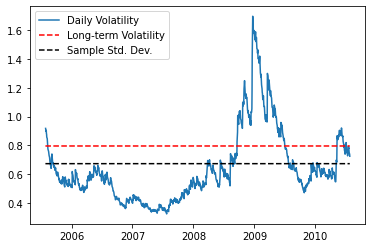

In [13]:
# Analysis and visualization of results 


#long-term volatility under GARCH
VL = omega / (1 - alpha - beta )
sigma_L = np.sqrt(VL) * 100 # measured in percentage
print('long-run volatiity under basic GARCH (1,1) is: ', sigma_L)

#sample standard deviation
print('Sample standard deviation is: ', sigma_sample)

#dynamic volatility under GARCH
v_GARCH = get_GARCH_volatility (omega, alpha, beta)
sigma_GARCH = np.sqrt(v_GARCH) * 100 # measured in percentage




plt.plot(dates[1:], sigma_GARCH , label = 'Daily Volatility')
plt.plot(dates[1:], sigma_L * np.ones(len(dates[1:])) , 'r--' , label = 'Long-term Volatility')
plt.plot(dates[1:], sigma_sample * np.ones(len(dates[1:])) , 'k--', label = 'Sample Std. Dev.' )
plt.legend()
# plt.savefig('GARCH.pdf')  
plt.show()



## EWMA 

In [14]:
#Implement the Maximum Likelihood Method for EWMA

x0 = .9 #Initial guess of lambda
print('Initial guess of the lambda: ', x0)
print('Objective function value for the initial guess: ', LL (x0, mode = 'EWMA'))
print('************')




res = opt.minimize( lambda x: - LL (x, mode = 'EWMA')  , x0, method='trust-constr',  options={'disp': True})

paras_optimal =  res.x

lamb = paras_optimal

print('************')
print('Optimal lambda: ', lamb)
print('Optimal value for the optimal solution : ', LL (paras_optimal, mode = 'EWMA'))



Initial guess of the lambda:  0.9
Objective function value for the initial guess:  11771.053816221454
************


/Users/austinbai/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/austinbai/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/austinbai/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defin

`xtol` termination condition is satisfied.
Number of iterations: 34, function evaluations: 64, CG iterations: 33, optimality: 1.22e-04, constraint violation: 0.00e+00, execution time: 0.65 s.
************
Optimal lambda:  [0.95838293]
Optimal value for the optimal solution :  11806.476666703174


/Users/austinbai/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Sample standard deviation is:  0.6724692995379226


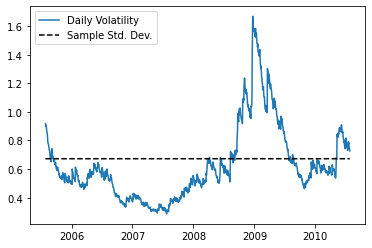

In [15]:
# Analysis and visualization of results 


#sample standard deviation
sigma_sample = np.std(r) * 100  # measured in percentage
print('Sample standard deviation is: ', sigma_sample)

#dynamic volatility under EWMA
v_EWMA = get_EWMA_volatility (lamb)
sigma_EWMA = np.sqrt(v_EWMA) * 100 # measured in percentage




plt.plot(dates[1:], sigma_EWMA , label = 'Daily Volatility')
plt.plot(dates[1:], sigma_sample * np.ones(len(dates[1:])) , 'k--', label = 'Sample Std. Dev.' )
plt.legend()
# plt.savefig('EWMA.pdf') 
plt.show()




# GARCH(1,1): Variance Targeting

In [16]:
#Implement the Maximum Likelihood Method for Basic GARCH(1,1)

x0 = (0.9, 0.9) #Initial guess of omega, alpha, and beta


alpha = x0[0]/10
beta = x0[1]

print('Initial guess of the (alpha, beta) configuration: ', (alpha, beta))
print('Objective function value for the initial guess: ', LL (x0, mode = 'GARCH-VT'))
print('************')



res = opt.minimize( lambda x: - LL (x, mode = 'GARCH-VT')  , x0, method='trust-constr',  options={'disp': True})

paras_optimal =  res.x

alpha = paras_optimal[0]/10
beta = paras_optimal[1]

print('************')
print('Optimal alpha: ', alpha)
print('Optimal beta: ',  beta)
print('Optimal value for the optimal solution : ', LL (paras_optimal, mode = 'GARCH-VT'))


Initial guess of the (alpha, beta) configuration:  (0.09, 0.9)
Objective function value for the initial guess:  11792.789914556086
************
`gtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 90, CG iterations: 43, optimality: 0.00e+00, constraint violation: 0.00e+00, execution time: 0.24 s.
************
Optimal alpha:  0.04330296948618008
Optimal beta:  0.9534213677855364
Optimal value for the optimal solution :  11811.055876338913


Sample standard deviation is:  0.6724692995379226


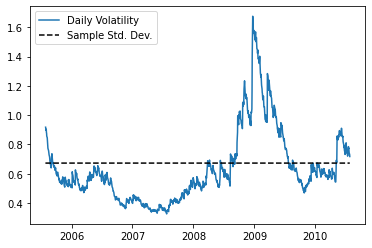

In [17]:
# Analysis and visualization of results 



#sample standard deviation
sigma_sample = np.std(r) * 100  # measured in percentage
print('Sample standard deviation is: ', sigma_sample)

#dynamic volatility under GARCH-VT
v_GARCH_VT = get_GARCH_VT_volatility (alpha, beta)
sigma_GARCH_VT  = np.sqrt(v_GARCH_VT) * 100 # measured in percentage




plt.plot(dates[1:], sigma_GARCH_VT , label = 'Daily Volatility')
plt.plot(dates[1:], sigma_sample * np.ones(len(dates[1:])) , 'k--', label = 'Sample Std. Dev.' )
plt.legend()
# plt.savefig('GARCH-VT.pdf') 
plt.show()



# Summary Graph

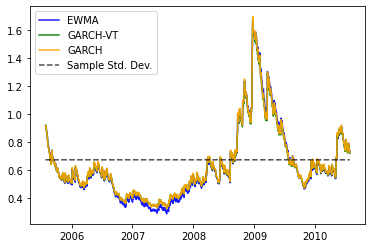

In [18]:
# VIX_normalized = vix['Adj Close']/( vix['Adj Close'].mean() / np.nanmean(sigma_GARCH) )
# VIX_normalized = VIX_normalized[1:] #exclusing the first day




plt.plot(dates[1:], sigma_EWMA, 'b' , label = 'EWMA', alpha = 0.9)
plt.plot(dates[1:], sigma_GARCH_VT, 'g' , label = 'GARCH-VT', alpha = 0.9)
plt.plot(dates[1:], sigma_GARCH , 'orange', label = 'GARCH', alpha = 0.9)

# plt.plot(dates[1:], VIX_normalized.values, 'r', label =  'VIX-normalized', alpha = 0.5)


plt.plot(dates[1:], sigma_sample * np.ones(len(dates[1:])) , 'k--', label = 'Sample Std. Dev.' , alpha = 0.7)

plt.legend()

#plt.xlim([pd.to_datetime ('2008-06-01'), pd.to_datetime ('2009-06-01')])

# plt.savefig('summary.pdf')  

plt.show()

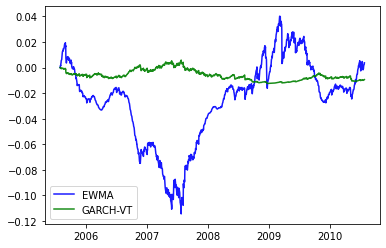

In [19]:
plt.plot(dates[1:], (sigma_EWMA - sigma_GARCH)/sigma_GARCH, 'b' , label = 'EWMA', alpha = 0.9)
plt.plot(dates[1:], (sigma_GARCH_VT - sigma_GARCH)/sigma_GARCH , 'g', label = 'GARCH-VT', alpha = 0.9)
# plt.plot(dates[1:], (VIX_normalized.values - sigma_GARCH)/sigma_GARCH, 'r', label =  'VIX-normalized', alpha = 0.5)





plt.legend()

#plt.xlim([pd.to_datetime ('2008-06-01'), pd.to_datetime ('2009-06-01')])

# plt.savefig('summary_related_error.pdf')  

plt.show()